<a href="https://colab.research.google.com/github/fishfishin/CT-denoise/blob/main/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
#import visdom
import torchvision.transforms as T
import skimage.external.tifffile
import copy
import cv2
import math
from torch.autograd import Variable
from math import exp
from skimage.restoration import denoise_nl_means
from google.colab import drive
"""
import tensorflow as tf
device_name = tf.test.gpu_device_name()

if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
"""
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  
print(dev)
#vis = visdom.Visdom()


def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = Variable(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
    return window

def _ssim(img1, img2, window, window_size, channel, size_average = True):
    mu1 = F.conv2d(img1, window, padding = window_size//2, groups = channel)
    mu2 = F.conv2d(img2, window, padding = window_size//2, groups = channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1*mu2

    sigma1_sq = F.conv2d(img1*img1, window, padding = window_size//2, groups = channel) - mu1_sq
    sigma2_sq = F.conv2d(img2*img2, window, padding = window_size//2, groups = channel) - mu2_sq
    sigma12 = F.conv2d(img1*img2, window, padding = window_size//2, groups = channel) - mu1_mu2

    C1 = 0.01**2
    C2 = 0.03**2

    ssim_map = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)

class SSIM(torch.nn.Module):
    def __init__(self, window_size = 11, size_average = True):
        super(SSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = 1
        self.window = create_window(window_size, self.channel)

    def forward(self, img1, img2):
        (_, channel, _, _) = img1.size()

        if channel == self.channel and self.window.data.type() == img1.data.type():
            window = self.window
        else:
            window = create_window(self.window_size, channel)
            
            if img1.is_cuda:
                window = window.cuda(img1.get_device())
            window = window.type_as(img1)
            
            self.window = window
            self.channel = channel


        return _ssim(img1, img2, window, self.window_size, channel, self.size_average)

def ssim(img1, img2, window_size = 11, size_average = True):
    (_, channel, _, _) = img1.size()
    window = create_window(window_size, channel)
    
    if img1.is_cuda:
        window = window.cuda(img1.get_device())
    window = window.type_as(img1)
    
    return _ssim(img1, img2, window, window_size, channel, size_average)

cuda:0


In [28]:
def PSNR(img1, img2):
    D = np.array(img1 - img2, dtype=np.float64)
    D[:, :] = D[:, :]**2
    RMSE = D.sum()/img1.size
    psnr = 10*math.log10(float(1095.**2)/RMSE)
    return psnr


def restore(img):
    image = torch.zeros(1,1,256,256)
    for  xcord in range(4):
      for ycord in range(4):
        image[0,0,xcord*64:(xcord+1)*64,ycord*64:(ycord+1)*64] = img[xcord * 4 + ycord, 0, :,:]

    return image


def non_overlapping(ground_truth, train_data):
    # part the image into 64x64 patches
    img1 = torch.zeros(16, 1, 64,64)
    img2 = torch.zeros(16, 1, 64,64)
    for xcord in range(4):
      for ycord in range(4):
        X = ground_truth[xcord*64:(xcord+1)*64,ycord*64:(ycord+1)*64] #### Ground Truth       
        img1[xcord * 4 + ycord, 0, :,:] = torch.from_numpy(X)
        X = train_data[xcord*64:(xcord+1)*64,ycord*64:(ycord+1)*64]     
        img2[xcord * 4 + ycord,0,:,:] = torch.from_numpy(X)

    return Variable(img1).cuda(), Variable(img2).cuda()

Streaming output truncated to the last 5000 lines.
 iteration: 6705
     loss of Autoencoder: 4737.50, ssim : 0.8285, psnr : 23.4420
     loss of Autoencoder: 4618.24, ssim : 0.8242, psnr : 23.5528
     loss of Autoencoder: 4600.17, ssim : 0.8307, psnr : 23.5698
     loss of Autoencoder: 4760.67, ssim : 0.8363, psnr : 23.4208
     loss of Autoencoder: 4866.59, ssim : 0.8237, psnr : 23.3253
     loss of Autoencoder: 5044.03, ssim : 0.8388, psnr : 23.1697
     loss of Autoencoder: 5457.72, ssim : 0.8202, psnr : 22.8274
     loss of Autoencoder: 5218.93, ssim : 0.8391, psnr : 23.0217
     loss of Autoencoder: 4707.64, ssim : 0.8270, psnr : 23.4695
     loss of Autoencoder: 4455.56, ssim : 0.8367, psnr : 23.7085
     loss of Autoencoder: 4329.88, ssim : 0.8366, psnr : 23.8328
     loss of Autoencoder: 4132.62, ssim : 0.8294, psnr : 24.0353
     loss of Autoencoder: 4027.16, ssim : 0.8339, psnr : 24.1475
     loss of Autoencoder: 4070.04, ssim : 0.8203, psnr : 24.1015
     loss of Autoencod

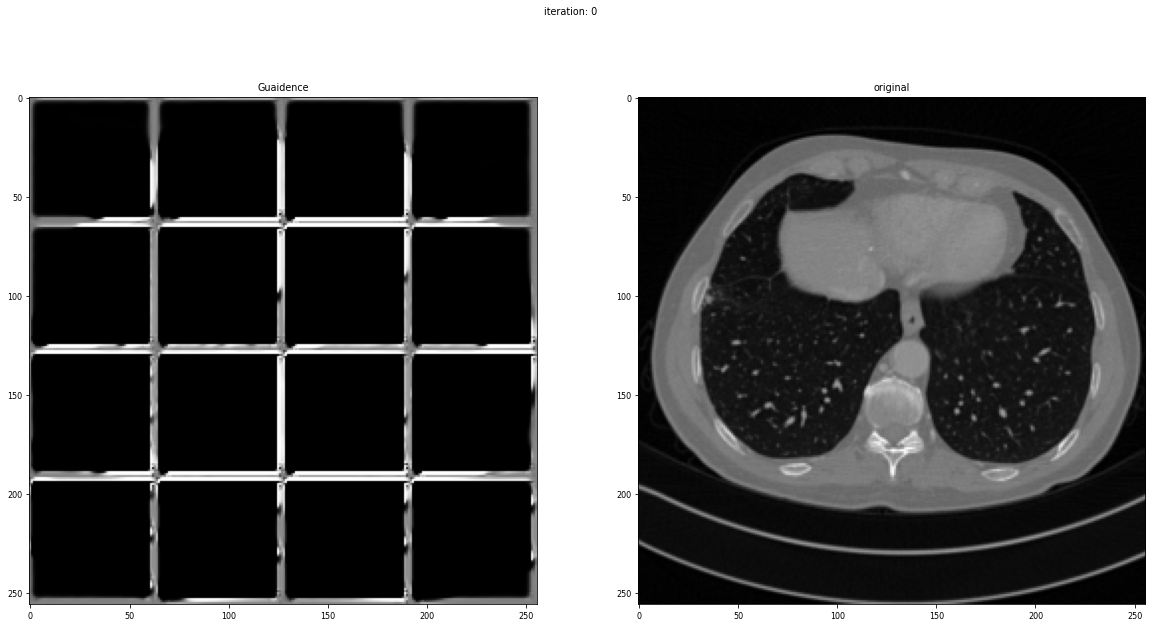

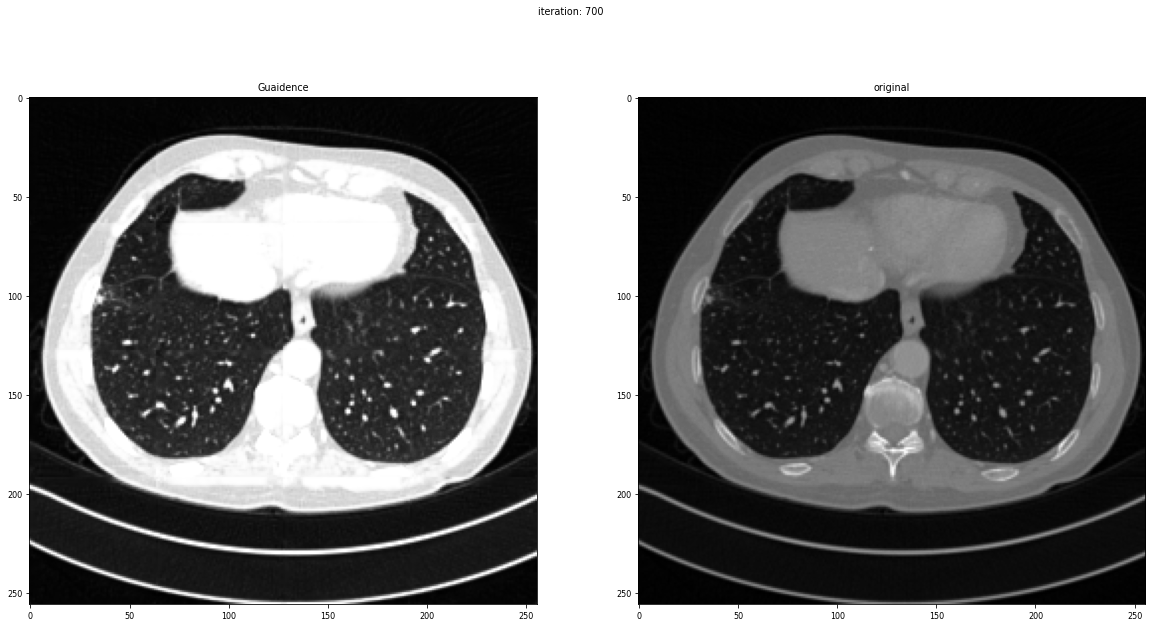

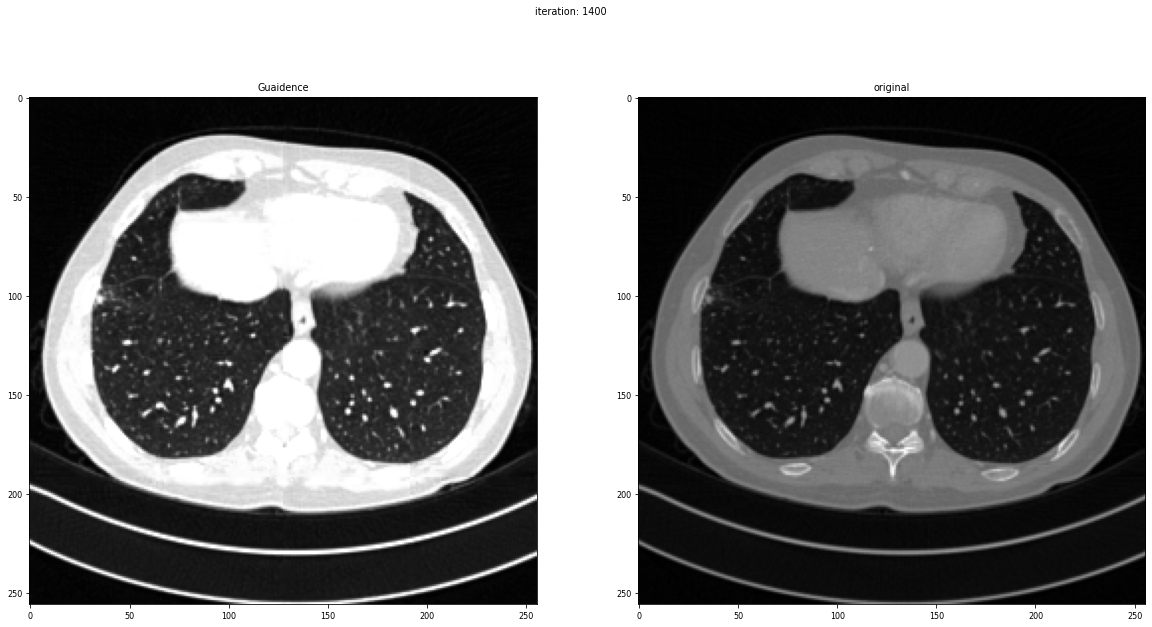

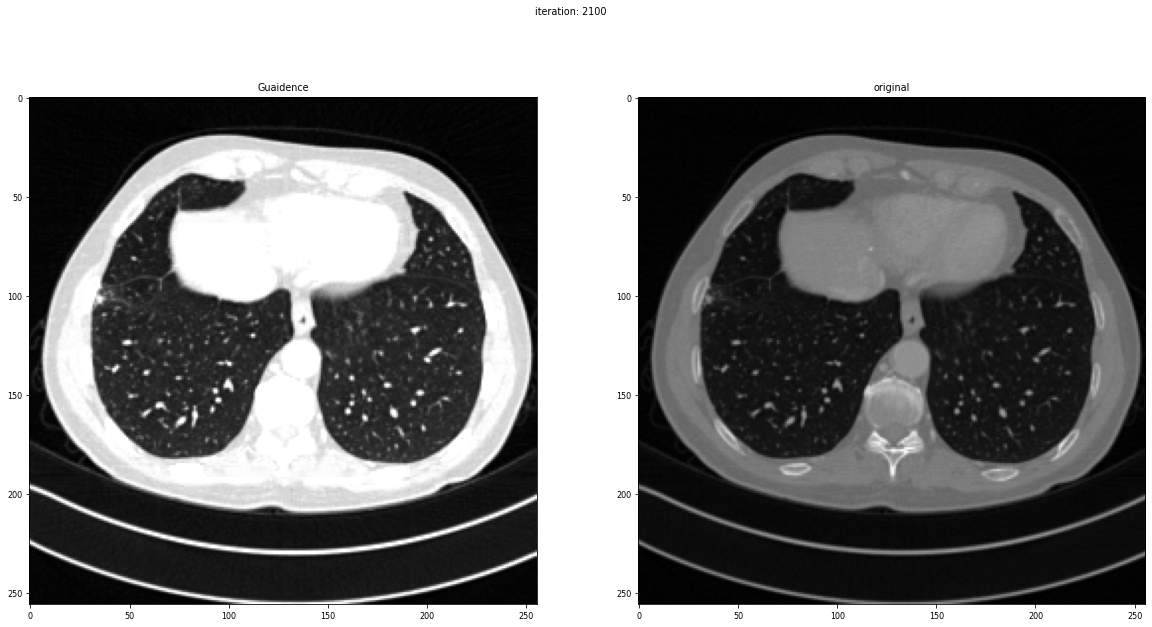

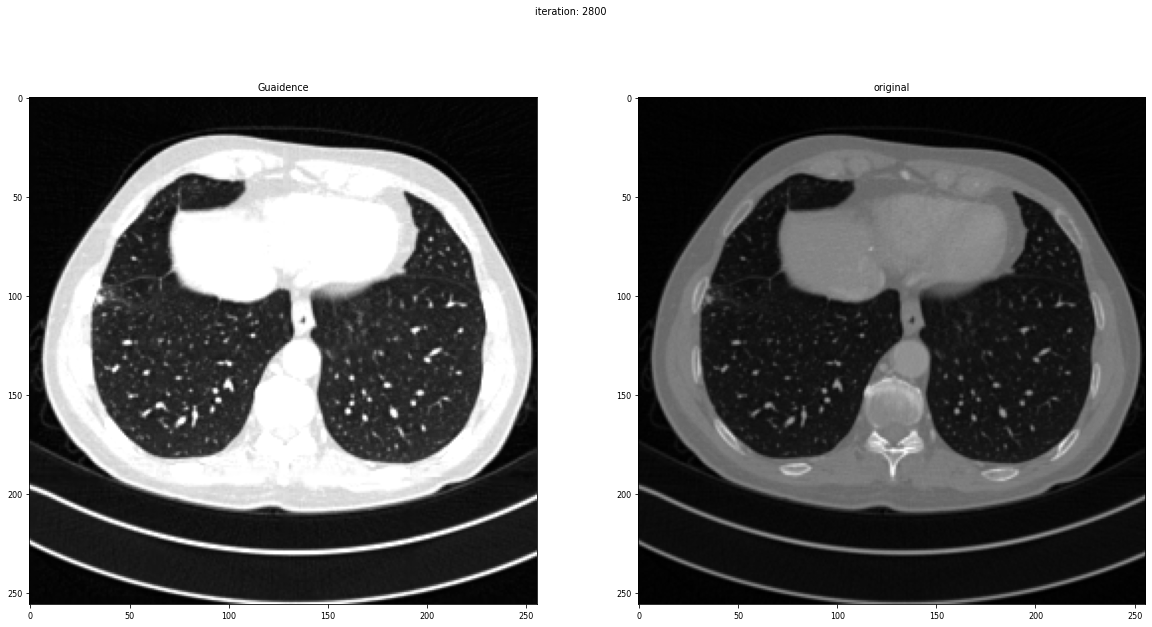

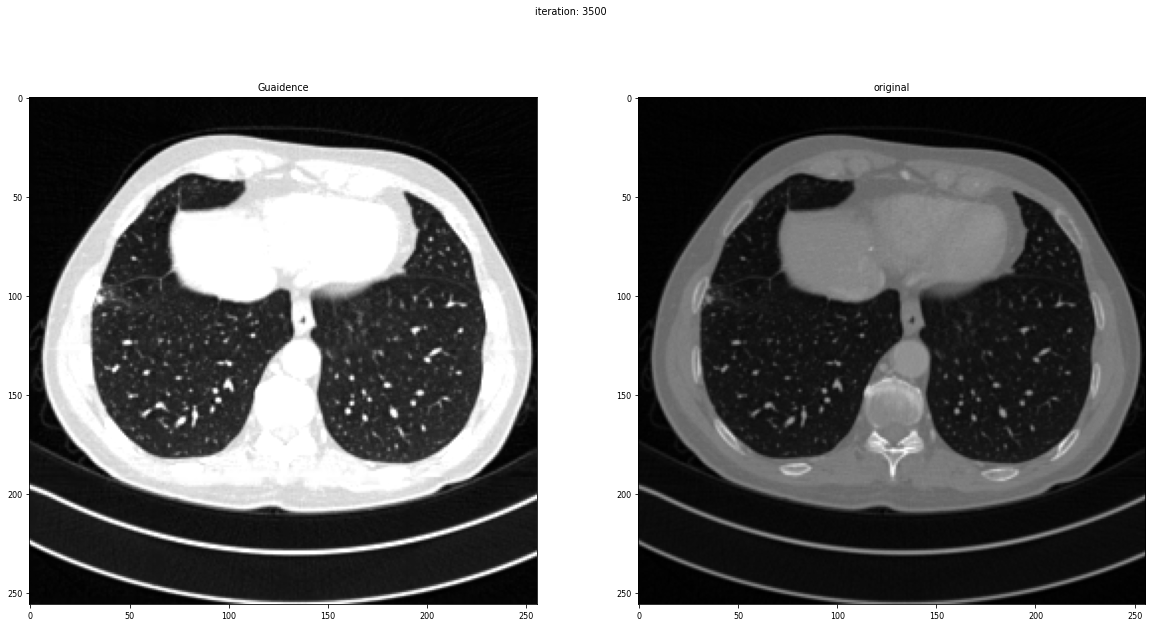

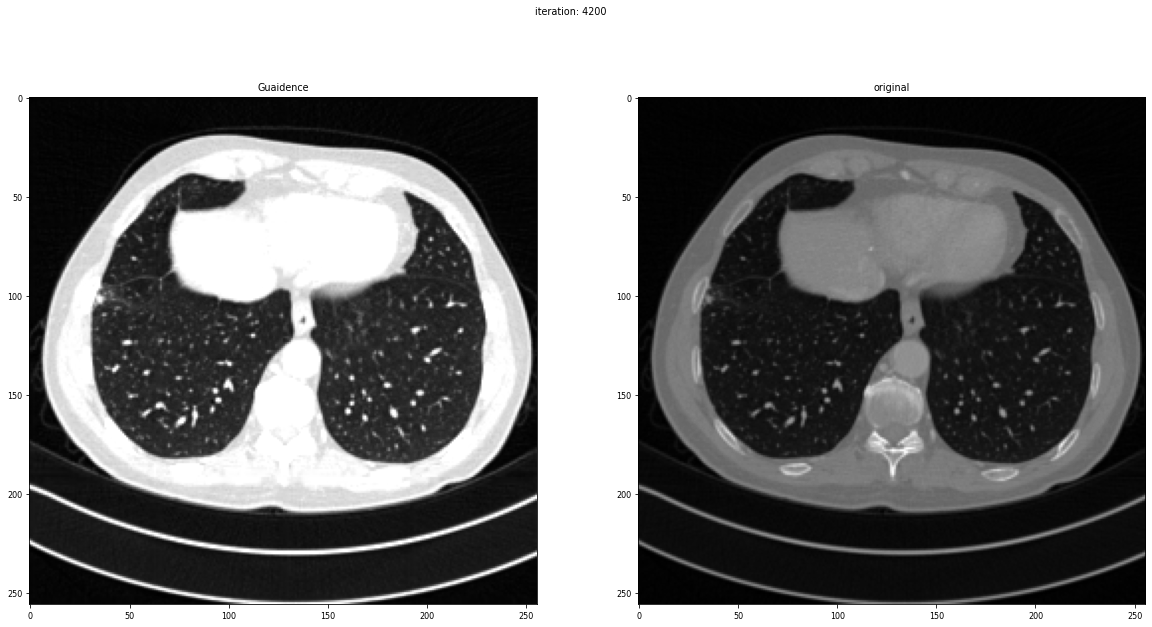

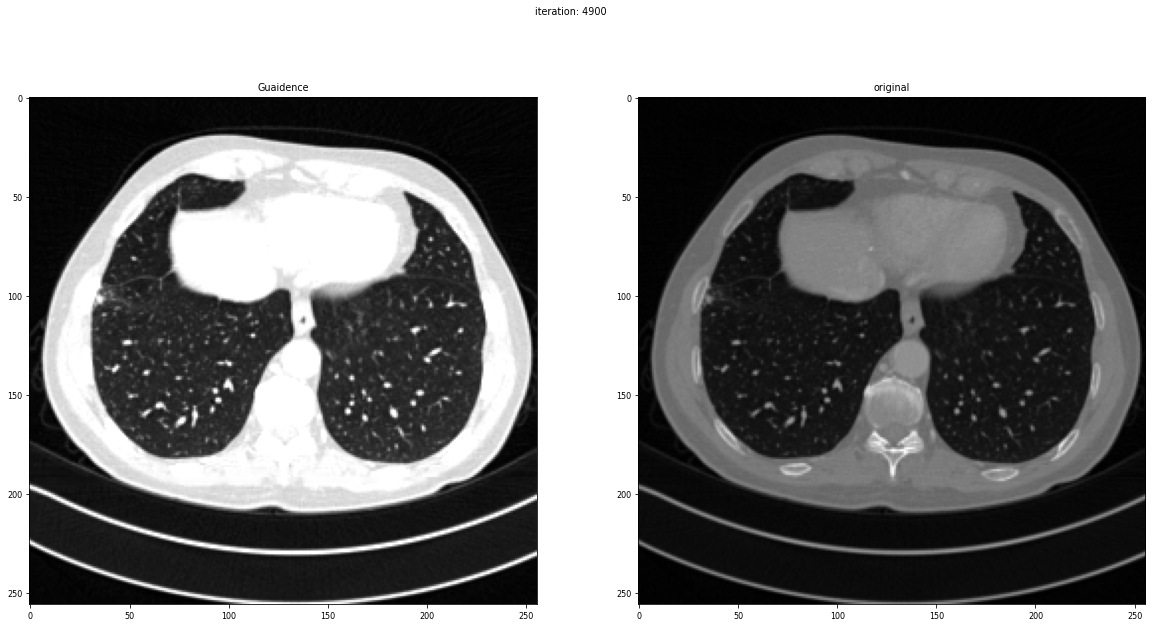

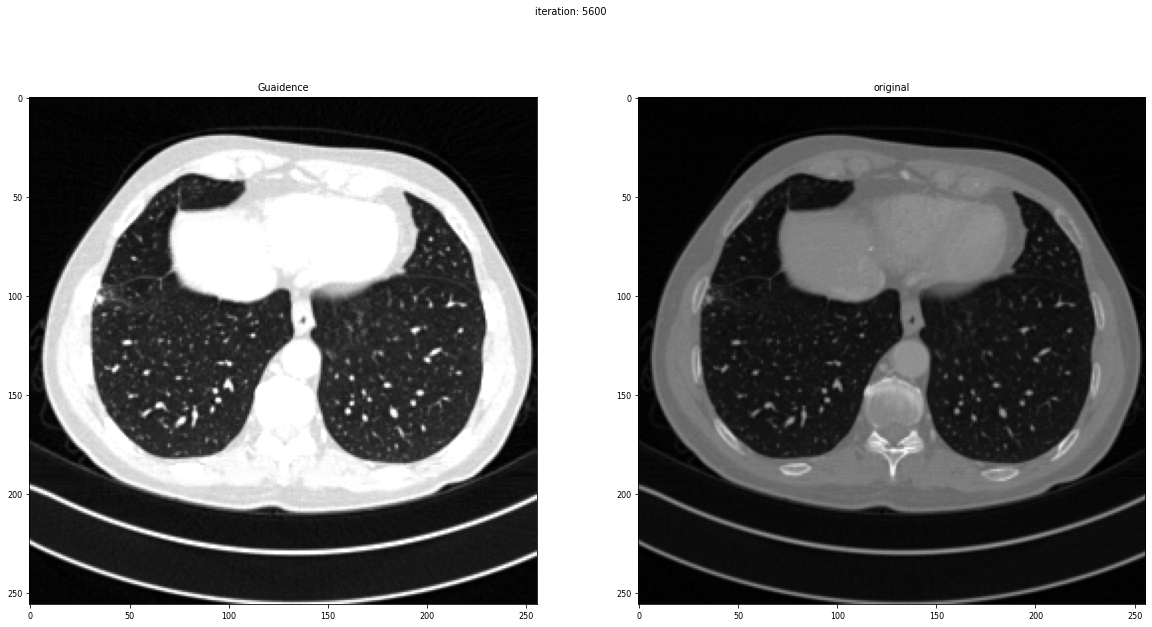

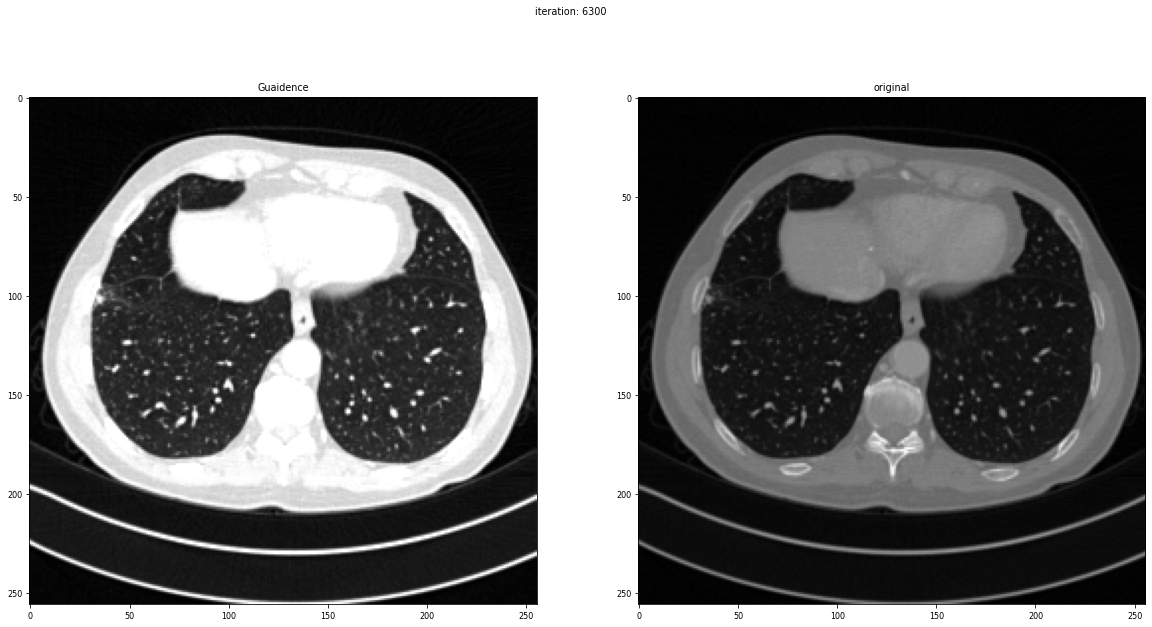

In [47]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 32,kernel_size=3)
        self.conv2 = nn.Conv2d(32, 32,kernel_size=3)
        self.conv3 = nn.Conv2d(32, 32,kernel_size=3)
        self.conv4 = nn.Conv2d(32, 32,kernel_size=3)
        self.deconv1 = nn.ConvTranspose2d(32, 32,kernel_size=3)
        self.deconv2 = nn.ConvTranspose2d(32, 32,kernel_size=3)
        self.deconv3 = nn.ConvTranspose2d(32, 32,kernel_size=3)
        self.deconv4 = nn.ConvTranspose2d(32, 1,kernel_size=3)
        self.tanh = nn.Tanh()
        self.opt = optim.Adam(self.parameters(), lr=0.0005)

    def forward(self, x):
        

        out = F.relu(self.conv1(x))
        residual_1 = out
        
        out = F.relu(self.conv2(out))
        residual_2 = out
        
        out = F.relu(self.conv3(out))
        residual_3 = out
        
        out = F.relu(self.conv4(out))  
        #print(out.shape)     
        out = F.relu(self.deconv1(out))      
        #out += residual_3
      
        out = F.relu(self.deconv2(out))
        #out += residual_2
      
        out = F.relu(self.deconv3(out))
        #out += residual_1
        
        out = torch.sigmoid(self.deconv4(out))
        
        
        return out

    def update(self, out,target):

        #out = self.forward(x)
        self.opt.zero_grad()
        
        loss = nn.MSELoss()
        upd_ = loss(out,target)
        upd_.backward()
        
        self.opt.step()

        return upd_

def main():

    #train_data = skimage.external.tifffile.imread("C:/Users/ZhenjuYin/Downloads/a1.tif")
    drive.mount('/content/drive')
    TrueImgTrain = skimage.external.tifffile.imread("drive/My Drive/Colab Notebooks/G.tif")
    print(TrueImgTrain.shape)
    TrueImgTrain = TrueImgTrain[:,:,:]
    datasize = TrueImgTrain.shape
    sigma = np.random.rand(2)
    
    re_cnn = autoencoder().cuda()

    for j in range(7000):
      count = 0
      sigma = np.random.rand(2)
      gaussian = np.random.normal(sigma[0], sigma[1], (datasize[0],datasize[1],datasize[2])) 
      train_data = TrueImgTrain + gaussian
      filtered = torch.zeros(16,1,64,64)

      for img_idx in TrueImgTrain:
        # part the image into 64x64 patches
        img1, img2 = non_overlapping(img_idx, train_data[count,:,:])
        img =  torch.mul(re_cnn(img2) , 1095.0)
        # store the current filtered image patches   
        filtered = img
        
        loss = re_cnn.update(img, img1)
        img = restore(img)
        img1 = torch.zeros(1,1,256,256)
        img1[0,0,:,:]= torch.from_numpy(img_idx)
        ssim_ = ssim(img1, img)
        psnr = PSNR(img1.cpu().detach().numpy(),img.cpu().detach().numpy())
        print("     loss of Autoencoder: {:.2f}, ssim : {:.4f}, psnr : {:.4f}".format(loss,ssim_,psnr))
        count +=1
      if j % 700 ==0:
        filtered = restore(filtered)[0,0,:,:]
        fig, axs = plt.subplots(1, 2,figsize=(20,10))
        fig.suptitle(" iteration: {}".format(j))
        axs[0].imshow(filtered.detach().numpy(), cmap='gray')
        axs[1].imshow(train_data[15,:,:], cmap='gray')
        axs[1].set_title('original')
        axs[0].set_title('Guaidence')
      print(" iteration: {}".format(j))

    # save the trained networks
    PATH = "drive/My Drive/Colab Notebooks/cnn"
    torch.save(re_cnn.state_dict(), PATH)
    device = torch.device("cuda")

    model = autoencoder()
    model.load_state_dict(torch.load(PATH))
    model.to(device)

if __name__ == '__main__':
    main()